<b>Data Augumentation</b>

In [1]:
import numpy as np
import torch

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# Dataset : Without Augumentation

from torchvision import datasets, transforms
import torch.utils as utils

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = datasets.STL10(
    './data', 
    split="train", 
    download=True, 
    transform=transform_train)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_test = datasets.STL10(
    './data', 
    split="test", 
    download=True, 
    transform=transform_test)

batch_size = 100

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Network

import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 4, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(4, 8, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(8, 16, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )
    self.fc = nn.Sequential(
        nn.Linear(16 * 12 * 12, 1000),
        nn.ReLU(),
        nn.Linear(1000, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
    )

  def forward(self, x1):
    x2 = self.conv(x1)
    x3 = x2.view(x2.size()[0], -1)
    x4 = self.fc(x3)
    return x4

In [4]:
# Training without data augmentation

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

nepoch = 100

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for i in range(nepoch):
  print(f"EPOCH: {i+1}")

  # initialize each epoch
  train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

  ### Train ###
  model.train()
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    model.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_correct = 0
  sum_iter = 0
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    _, predicted = y.max(1)
    sum_loss += loss.cpu().detach().numpy()
    sum_correct += (predicted == t).sum().item()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")
  print(f"  train acc : {sum_correct/(sum_iter*batch_size)}")

  # append list for polt graph after training
  train_loss_list.append(sum_loss/sum_iter)
  train_acc_list.append(sum_correct/(sum_iter*batch_size))

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_correct = 0
  sum_iter = 0
  for x, t in dataloader_test:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    _, predicted = y.max(1)
    sum_loss += loss.cpu().detach().numpy()
    sum_correct += (predicted == t).sum().item()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")
  print(f"  test  acc : {sum_correct/(sum_iter*batch_size)}")

  # append list for polt graph after training
  val_loss_list.append(sum_loss/sum_iter)
  val_acc_list.append(sum_correct/(sum_iter*batch_size))


Net(
  (conv): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
EPOCH: 1
  train loss: 2.3028736400604246
  train acc : 0.1
  test  loss: 2.30293245613575
  test  acc : 0.1
EPOCH: 2
  train loss: 2.301879243850708
  train acc : 0.1
  test  loss: 2.30196613073349
  te

In [5]:
# ======== eval_mode (test samples) ======
model.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in dataloader_test:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 41.925 %


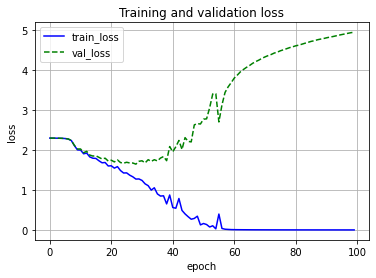

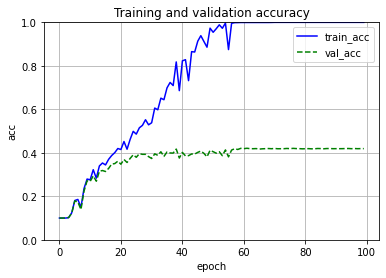

In [6]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(nepoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, color='green', linestyle='--', label='val_loss')
#plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_STL10_loss_noaug.png')
plt.show()

plt.figure()
plt.plot(range(nepoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(nepoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_STL10_acc_noaug.png')
plt.show()

## Data Augumentation

In [7]:
# Dataset : With Augumentation

from torchvision import datasets, transforms
import torch.utils as utils

### Augumentation ###
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5.0, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = datasets.STL10(
    './data', 
    split="train", 
    download=True, 
    transform=transform_train)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_test = datasets.STL10(
    './data', 
    split="test", 
    download=True, 
    transform=transform_test)

batch_size = 100

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

dataloader_test = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Training

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()

nepoch = 100

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for i in range(nepoch):
  print(f"EPOCH: {i+1}")

  # initialize each epoch
  train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

  ### Train ###
  model.train()
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    model.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_correct = 0
  sum_iter = 0
  for x, t in dataloader_train:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    _, predicted = y.max(1)
    sum_loss += loss.cpu().detach().numpy()
    sum_correct += (predicted == t).sum().item()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")
  print(f"  train acc : {sum_correct/(sum_iter*batch_size)}")

  # append list for polt graph after training
  train_loss_list.append(sum_loss/sum_iter)
  train_acc_list.append(sum_correct/(sum_iter*batch_size))

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_correct = 0
  sum_iter = 0
  for x, t in dataloader_test:
    x = x.to(device)
    t = t.to(device)
    y = model(x)
    loss = criterion(y, t)
    _, predicted = y.max(1)
    sum_loss += loss.cpu().detach().numpy()
    sum_correct += (predicted == t).sum().item()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")
  print(f"  test  acc : {sum_correct/(sum_iter*batch_size)}")

  # append list for polt graph after training
  val_loss_list.append(sum_loss/sum_iter)
  val_acc_list.append(sum_correct/(sum_iter*batch_size))


Net(
  (conv): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
EPOCH: 1
  train loss: 2.3041310262680055
  train acc : 0.1
  test  loss: 2.3041152566671372
  test  acc : 0.1
EPOCH: 2
  train loss: 2.303871726989746
  train acc : 0.1
  test  loss: 2.3038525104522707


In [9]:
# ======== eval_mode (test samples) ======
model.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in dataloader_test:        
#        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 52.5 %


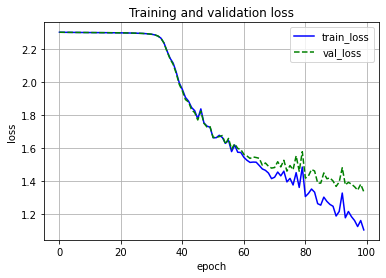

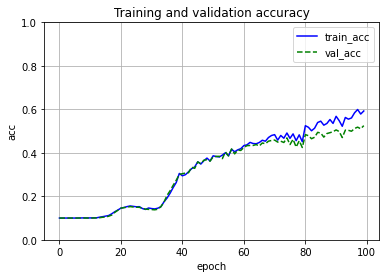

In [10]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(nepoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, color='green', linestyle='--', label='val_loss')
#plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('CNN_STL10_loss_aug.png')
plt.show()

plt.figure()
plt.plot(range(nepoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(nepoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.0, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('CNN_STL10_acc_aug.png')
plt.show()

参考<br>
https://qiita.com/shoheihoh/items/137141864394c3e4866b